<a href="https://colab.research.google.com/github/hmin27/2023_DL_Clip/blob/main/CLIP(ZeroShot).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

# Load CLIP model

In [ ]:
import numpy as np
import torch
from pkg_resources import packaging
import pandas as pd
import clip
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt


print("Torch version:", torch.__version__)

Torch version: 2.1.0+cu118


In [ ]:
# 드라이브에 연결

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Load the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-B/32', device)

# Zero shot Image Classification

In [ ]:
# Creating image path, text list
import pandas as pd
import os

data_folder = '/content/drive/MyDrive/Study/DL_CLIP/Food_fewshot/4_shot/test'

image_paths = []
text_descriptions = []
class_folders = sorted(os.listdir(data_folder))

for class_folder in class_folders:
    class_folder_path = os.path.join(data_folder, class_folder)
    image_files = sorted(os.listdir(class_folder_path))

    # Create text description using class label
    text_description = f"a photo of {class_folder.replace('_',' ')}"
    text_descriptions.append(text_description)

    for image_file in image_files:
        image_path = os.path.join(class_folder_path, image_file)
        image_paths.append(image_path)



print(text_descriptions)  # 33개
print(len(image_paths))  # 132개

5
torch.Size([33, 77])


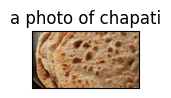

In [ ]:
data_root = '/content/drive/MyDrive/Study/DL_CLIP/Food_fewshot/4_shot/test'

dataset = ImageFolder(data_root)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# Prepare the inputs
image, class_id = dataset[20]
print(class_id)
plt.subplot(2, 4, 2)
plt.imshow(image)
plt.title(f"{text_descriptions[class_id]}")
plt.xticks([])
plt.yticks([])

image_input = preprocess(image).unsqueeze(0).to(device)
text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in dataset.classes]).to(device)

print(text_inputs.shape)

In [ ]:
# Calculate features
with torch.no_grad():
    image_features = model.encode_image(image_input)
    text_features = model.encode_text(text_inputs)

# Pick the top 5 most similar labels for the image
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
values, indices = similarity[0].topk(10)

In [ ]:
# Print the result
print("\nTop predictions:\n")
for value, index in zip(values, indices):
    print(f"{dataset.classes[index]:>16s}: {100 * value.item():.2f}%")


Top predictions:

         chapati: 50.63%
   chole_bhature: 28.42%
     butter_naan: 11.13%
     masala_dosa: 3.67%
      paani_puri: 2.52%
     dal_makhani: 1.17%
            idli: 0.71%
       pav_bhaji: 0.48%
          dhokla: 0.39%
            taco: 0.22%


In [ ]:

all_predictions_top1 = []
all_predictions_top3 = []

with torch.no_grad():
    for index in range(len(dataset)):
        image, class_id = dataset[index]

        image_input = preprocess(image).unsqueeze(0).to(device)
        text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in dataset.classes]).to(device)

        # Calculate features
        image_features = model.encode_image(image_input)
        text_features = model.encode_text(text_inputs)

        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)
        similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)

        # Top1 and Top3 Accuracy
        values, indices = similarity[0].topk(1)
        top1_prediction = indices.item()
        all_predictions_top1.append(top1_prediction)

        values_top3, indices_top3 = similarity[0].topk(3)
        top3_predictions = indices_top3.tolist()
        all_predictions_top3.append(top3_predictions)

# Calculate the top-1 accuracy
correct_predictions_top1 = sum([1 for pred, (_, true_label) in zip(all_predictions_top1, dataset.imgs) if pred == true_label])
accuracy_top1 = correct_predictions_top1 / len(dataset)

# Calculate the top-3 accuracy
correct_predictions_top3 = sum([1 for pred, (_, true_label) in zip(all_predictions_top3, dataset.imgs) if true_label in pred])
accuracy_top3 = correct_predictions_top3 / len(dataset)

print(f"Top-1 accuracy: {accuracy_top1 * 100:.2f}%")
print(f"Top-3 accuracy: {accuracy_top3 * 100:.2f}%")

Top-1 accuracy: 82.58%
Top-3 accuracy: 93.18%
